<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/PreTrained_benign_vs_malign_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Project Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Benign-Malign")

# to produce final model report histogram 
AUC_values = []
TPR_values = []
FPR_values = []
PRECISION_values = []
SPECIFICITY_values = []

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


##1.1 Utility Functions

In [ ]:
# ----------------------- Utility Functions -----------------------
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify benign and malign cases 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    #Precision = TP/(TP+FP)
      #Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
    precision = TP / (TP + FP)

    #Recall/Sensitivity/TPR = TP/(TP+FN)
        #Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
    tpr = TP / (TP + FN)

    #Specificity = TN/(TN+FP)
        #Specifity answers the following question: Of all the people who are healthy, how many of those did we correctly predict?
    specificity = TN / (TN + FP)

    #FPR  = 1 - Specificity =  FP/FP+TN
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity

Done


##1.2 Visualization Functions

In [ ]:
# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt


def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt
print("Done")

Done


#2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


##2.1 Data Visualization

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

def display_samples(abnormality_type):
  idx = 0
  counter = 0

  fig = figure(figsize=(20,4))
  while counter < 5:
    #benign masses 
    if test_labels[idx] == abnormality_type:
      img = test_images[idx]
      pil_img = tf.keras.preprocessing.image.array_to_img(img)
      a=fig.add_subplot(1, 5, counter+1)
      imshow(pil_img,cmap='Greys_r')
      axis('off')

      counter += 1
    idx += 1

Benign Masses[first row] VS Malign Masses[second row]


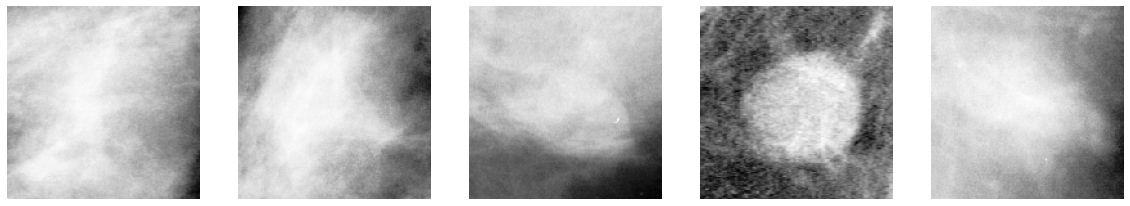

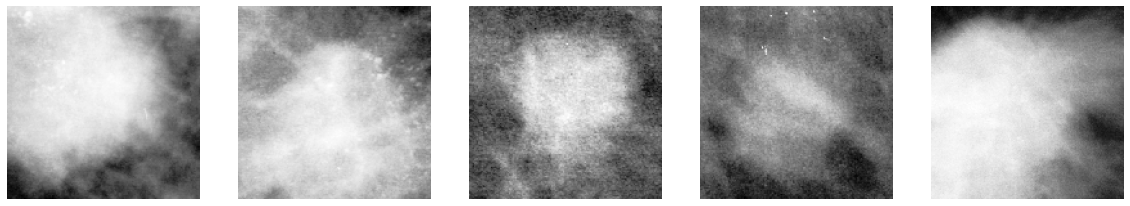

In [ ]:
#benign masses 
print("Benign Masses[first row] VS Malign Masses[second row]")
display_samples(1)

#benign calcifications
display_samples(2)

Benign Calcifications[first row] VS Malign Calcifications[second row]


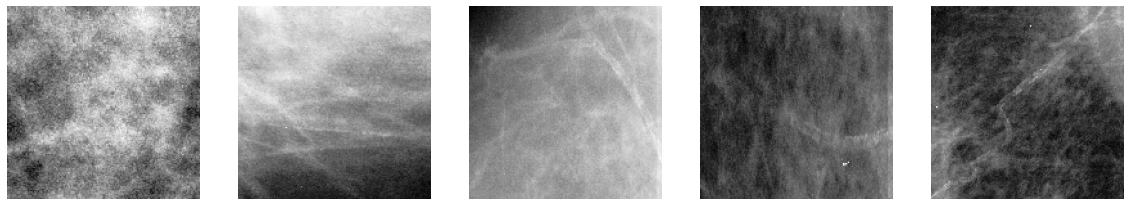

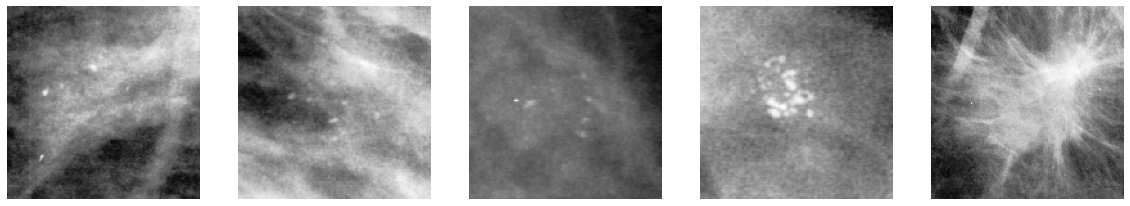

In [ ]:
print("Benign Calcifications[first row] VS Malign Calcifications[second row]")
display_samples(3)

display_samples(4)

##2.2 Data Preprocessing

In [ ]:
#1: Mass, benign
#2: Mass, malignant
#3: Calcification, benign
#4: Calcification, malignant

#count #of masses and #of calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[0])
print("Malign Masses samples: \t", counts[1])
print("Benign Calc samples: \t", counts[2])
print("Malign Calc samples: \t", counts[3])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])
print()

#train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
#test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

Benign samples:  1568
Malign samples:  1108

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)                                  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


##2.3 Global Contrast Normalization

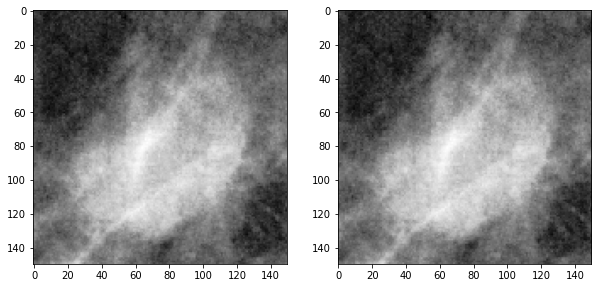

In [ ]:
#Global Contrast Normalization 
import numpy
import scipy
import scipy.misc
from PIL import Image

def global_contrast_normalization(X):
    X_average = numpy.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average
    return X

#nomalize image
norm_image = global_contrast_normalization(train_images[200])

original_image = tf.keras.preprocessing.image.array_to_img(train_images[200])
norm_image = tf.keras.preprocessing.image.array_to_img(norm_image)

#display images 
fig = figure(figsize=(10,5))
a=fig.add_subplot(1, 2, 1)
imshow(original_image,cmap='Greys_r')
a=fig.add_subplot(1, 2, 2)
imshow(norm_image,cmap='Greys_r')

In [ ]:
# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 


counter = 0
for image, label in train_datagen.flow(train_images_split, train_labels_split, batch_size=1, shuffle=False):
  #nomalize image
  norm_image = global_contrast_normalization(image)
  train_images_split[counter] = norm_image
  train_labels_split[counter] = label

  counter += 1
  if counter == len(train_images_split):
    break

print(train_images_split.shape)
print(train_labels_split.shape)

  #image = image.reshape(150, 150)
  #norm_image = norm_image.reshape(150, 150)

  #display images 
  #fig = figure(figsize=(10,5))
  #a=fig.add_subplot(1, 2, 1)
  #imshow(image,cmap='Greys_r')
  #a=fig.add_subplot(1, 2, 2)
  #imshow(norm_image,cmap='Greys_r')
  #break


(1873, 150, 150, 1)
(1873,)


##2.4 Data Augmentation

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


##2.5 All-in-one Data Preparation Function

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all-in-one data loading & preprocessing function 
def init_data(base_NN, GCN=True, augmentation=True):
  # Get images and labels (test, train)
  train_images, train_labels, test_images, test_labels = load_training()

  # Get abnormalities only 
  train_images = remove_baseline(train_images)
  train_labels = remove_baseline(train_labels)
  test_images = remove_baseline(test_images)
  test_labels = remove_baseline(test_labels)

  # Suffle index (Previous dataset is ordered)
  train_images, train_labels = shuffle_dataset(train_images, train_labels)

  #print("Train shape: ", train_images.shape)
  #print("Test shape: ", test_images.shape)

  #1: Mass, benign
  #2: Mass, malignant
  #3: Calcification, benign
  #4: Calcification, malignant

  #count #of masses and #of calcifications
  #unique, counts = np.unique(train_labels, return_counts=True)
  #print(unique, counts)

  #print("Benign Masses samples: \t", counts[0])
  #print("Malign Masses samples: \t", counts[1])
  #print("Benign Calc samples: \t", counts[2])
  #print("Malign Calc samples: \t", counts[3])

  #labels remapping
  train_labels = labels_mapping(train_labels)
  test_labels = labels_mapping(test_labels)

  #tensors reshaping for models training 
  train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
  test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
  #print(train_images.shape)
  #print(test_images.shape)

  # split dataset into training and validation set 70-30
  train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

  # All images will be rescaled by 1./65535
  if  base_NN == "VGG16":
    from tensorflow.keras.applications.vgg16 import preprocess_input
  if base_NN == "ResNet50":
    from tensorflow.keras.applications.resnet import preprocess_input
  #if Inception no preprocess function 
  if base_NN == "InceptionV3":
    train_datagen = ImageDataGenerator(rescale=1./65535)
    valid_datagen = ImageDataGenerator(rescale=1./65535)
    test_datagen = ImageDataGenerator(rescale=1./65535) 

  if "InceptionV3" not in base_NN:
    train_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    valid_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input) 

  if GCN:
    train_images_split_gcn = np.zeros(train_images_split.shape)  
    train_labels_split_gcn = np.zeros(train_labels_split.shape)
    valid_images_split_gcn = np.zeros(valid_images_split.shape)
    valid_labels_split_gcn = np.zeros(valid_labels_split.shape)
    train_datagen = ImageDataGenerator()
    valid_datagen = ImageDataGenerator()
    #global contrast normalization 
    counter = 0
    for image, label in train_datagen.flow(train_images_split, train_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image)
      train_images_split_gcn[counter] = norm_image
      train_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(train_images_split):
        break
    
    counter = 0
    for image, label in valid_datagen.flow(valid_images_split, valid_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image)
      valid_images_split_gcn[counter] = norm_image
      valid_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(valid_images_split):
        break
    if base_NN == "InceptionV3":  
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn))
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn))     
    else:
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn), preprocessing_function=preprocess_input)
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn), preprocessing_function=preprocess_input)      

  if GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  if not GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  print("Done")
  if GCN:
    #reshape to expand grayscale to rgb
    train_images_split_gcn = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split_gcn = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split_gcn, valid_images_split_gcn, train_labels_split_gcn, valid_labels_split_gcn, train_datagen, valid_datagen, test_datagen
  else:
    #reshape to expand grayscale to rgb
    train_images_split = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen

# 3.VGG16



##3.1.0 0-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_0FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 8s 82ms/step - loss: 1.0941 - acc: 0.6443 - val_loss: 0.6127 - val_acc: 0.6263
Epoch 2/30
93/93 [==============================] - 7s 80ms/step - loss: 0.6143 - acc: 0.6365 - val_l

KeyboardInterrupt: ignored

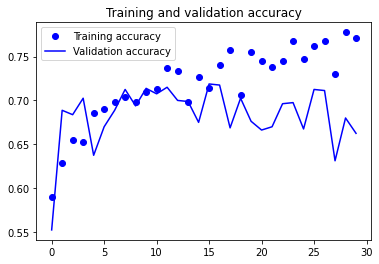

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

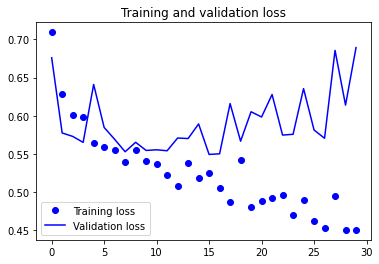

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 58ms/step - loss: 0.5949 - acc: 0.6625

---------------------------------
Accuracy: 66.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       219
         1.0       0.51      0.47      0.49       117

    accuracy                           0.66       336
   macro avg       0.62      0.61      0.62       336
weighted avg       0.65      0.66      0.65       336



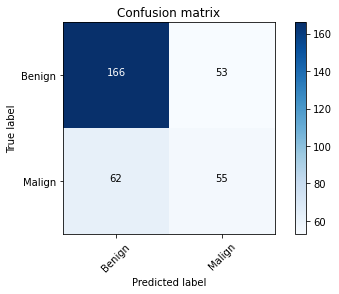

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

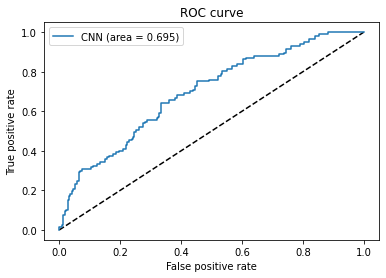

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  55
FP:  53
TN:  166
FN:  62

TPR(Recall): 		 0.4701
FPR: 			 0.242

Precision: 		 0.5093
TNR(Specificity): 	 0.758


In [ ]:
#free RAM 
del model
del conv_base

##3.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_0FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 13s 134ms/step - loss: 0.9557 - acc: 0.5318 - val_loss: 0.6464 - val_acc: 0.5688
Epoch 2/100
93/93 [==============================] - 12s 131ms/step - loss: 0.6365 - acc: 0.6077 -

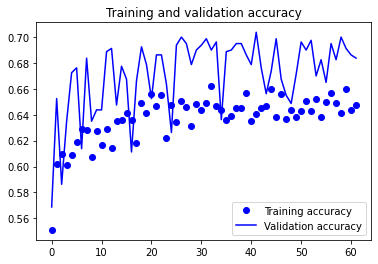

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

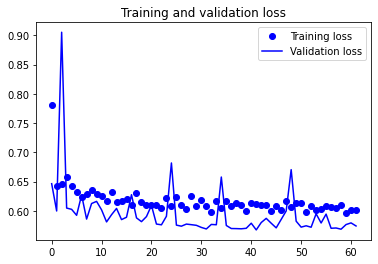

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 54ms/step - loss: 0.6118 - acc: 0.6313

---------------------------------
Accuracy: 63.13 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70       219
         1.0       0.47      0.53      0.50       117

    accuracy                           0.63       336
   macro avg       0.60      0.61      0.60       336
weighted avg       0.64      0.63      0.63       336



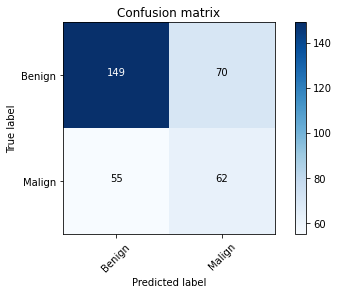

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

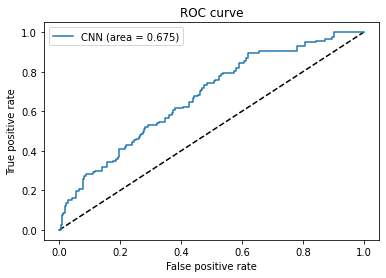

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  62
FP:  70
TN:  149
FN:  55

TPR(Recall): 		 0.5299
FPR: 			 0.3196

Precision: 		 0.4697
TNR(Specificity): 	 0.6804


In [ ]:
#free RAM 
del model
del conv_base

##3.2.0 1-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_1FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last convolutional block 
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 8s 85ms/step - loss: 0.8189 - acc: 0.5850 - val_loss: 0.6383 - val_acc: 0.6363
Epoch 2/30
93/93 [==============================] - 8s 86ms/step - loss: 0.6119 - acc: 0.6508 - val_l

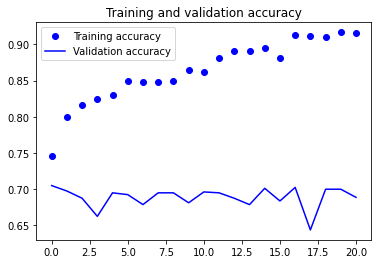

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

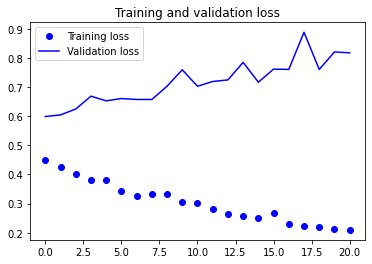

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 58ms/step - loss: 0.6308 - acc: 0.6875

---------------------------------
Accuracy: 68.75 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76       219
         1.0       0.54      0.47      0.50       117

    accuracy                           0.68       336
   macro avg       0.64      0.63      0.63       336
weighted avg       0.67      0.68      0.67       336



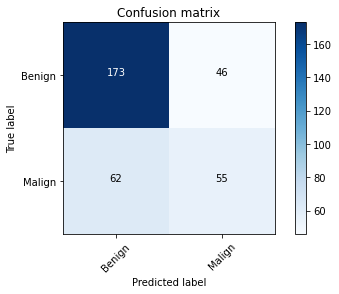

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

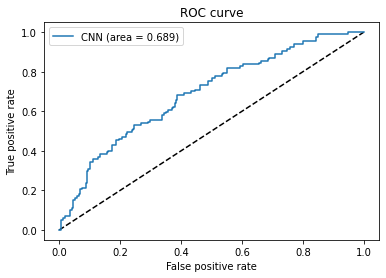

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  55
FP:  46
TN:  173
FN:  62

TPR(Recall): 		 0.4701
FPR: 			 0.21

Precision: 		 0.5446
TNR(Specificity): 	 0.79


##3.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_1FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last convolutional block 
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 21s 139ms/step - loss: 0.8943 - acc: 0.5498 - val_loss: 0.6451 - val_acc: 0.6100
Epoch 2/100
93/93 [==============================] - 12s 133ms/step - loss: 0.6518 - acc: 0.6229 - v

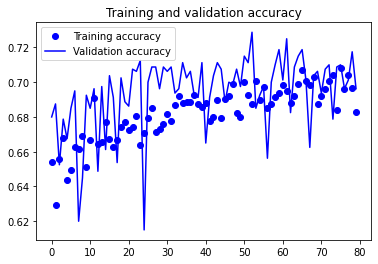

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

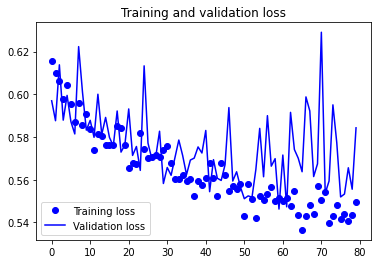

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 58ms/step - loss: 0.5992 - acc: 0.6438

---------------------------------
Accuracy: 64.38 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.66      0.70       219
         1.0       0.48      0.58      0.53       117

    accuracy                           0.63       336
   macro avg       0.61      0.62      0.61       336
weighted avg       0.65      0.63      0.64       336



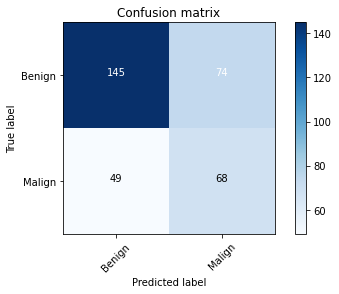

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

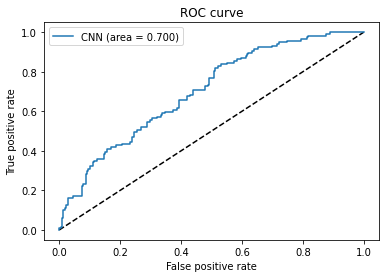

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  68
FP:  74
TN:  145
FN:  49

TPR(Recall): 		 0.5812
FPR: 			 0.3379

Precision: 		 0.4789
TNR(Specificity): 	 0.6621


In [ ]:
#free RAM 
del model
del conv_base

## 3.3 2-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_2FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 9s 86ms/step - loss: 0.8573 - acc: 0.6053 - val_loss: 0.6100 - val_acc: 0.6750
Epoch 2/30
93/93 [==============================] - 8s 87ms/step - loss: 0.6327 - acc: 0.6110 - val_l

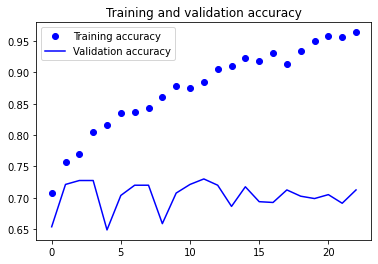

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

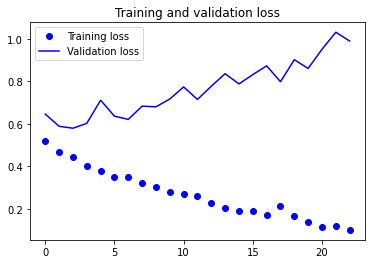

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 55ms/step - loss: 0.7291 - acc: 0.7250

---------------------------------
Accuracy: 72.50 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.74      0.77       219
         1.0       0.58      0.67      0.62       117

    accuracy                           0.72       336
   macro avg       0.69      0.71      0.70       336
weighted avg       0.73      0.72      0.72       336



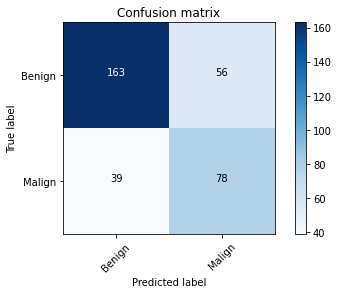

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

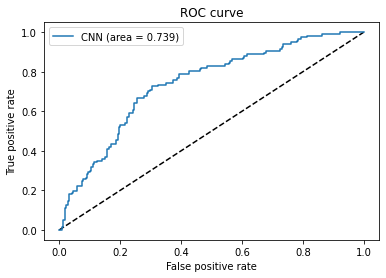

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  78
FP:  56
TN:  163
FN:  39

TPR(Recall): 		 0.6667
FPR: 			 0.2557

Precision: 		 0.5821
TNR(Specificity): 	 0.7443


In [ ]:
#free RAM 
del model
del conv_base

## 3.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_2FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 13s 132ms/step - loss: 0.8567 - acc: 0.6192 - val_loss: 0.8706 - val_acc: 0.5863
Epoch 2/100
93/93 [==============================] - 12s 131ms/step - loss: 0.6965 - acc: 0.5915 -

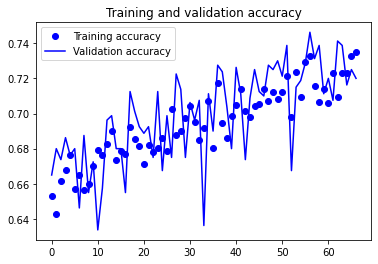

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

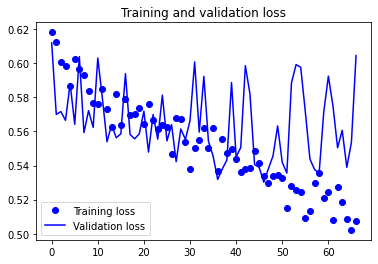

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 57ms/step - loss: 0.6301 - acc: 0.6344

---------------------------------
Accuracy: 63.44 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68       219
         1.0       0.47      0.65      0.55       117

    accuracy                           0.62       336
   macro avg       0.62      0.63      0.61       336
weighted avg       0.66      0.62      0.63       336



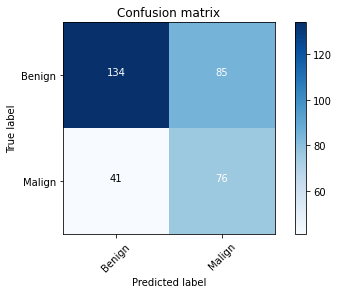

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

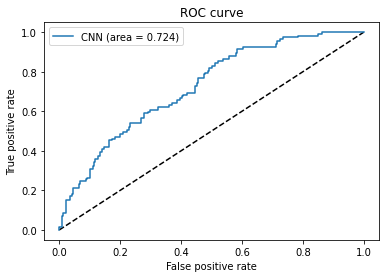

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  76
FP:  85
TN:  134
FN:  41

TPR(Recall): 		 0.6496
FPR: 			 0.3881

Precision: 		 0.472
TNR(Specificity): 	 0.6119


In [ ]:
#free RAM 
del model
del conv_base

## 3.4.1 3-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_3FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 8s 82ms/step - loss: 0.8111 - acc: 0.5829 - val_loss: 0.5922 - val_acc: 0.6550
Epoch 2/30
93/93 [==============================] - 8s 82ms/step - loss: 0.6420 - acc: 0.6428 - val_l

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

NameError: ignored

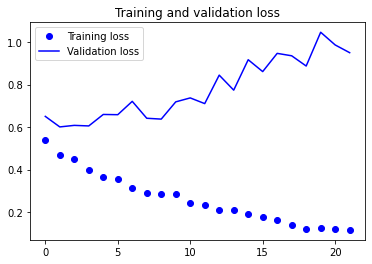

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 57ms/step - loss: 0.6274 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       219
         1.0       0.58      0.54      0.56       117

    accuracy                           0.70       336
   macro avg       0.67      0.66      0.67       336
weighted avg       0.70      0.70      0.70       336



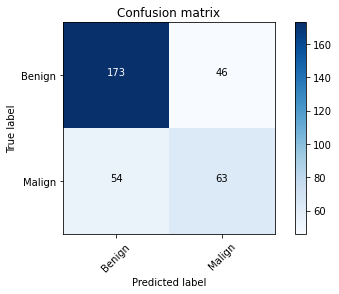

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

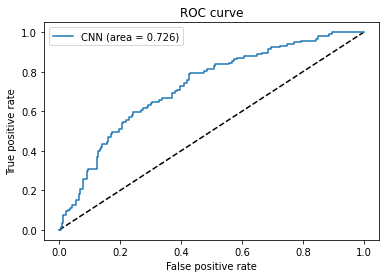

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  63
FP:  46
TN:  173
FN:  54

TPR(Recall): 		 0.5385
FPR: 			 0.21

Precision: 		 0.578
TNR(Specificity): 	 0.79


In [ ]:
#free RAM 
del model
del conv_base

## 3.4.2 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 21s 138ms/step - loss: 0.8194 - acc: 0.5695 - val_loss: 0.6150 - val_acc: 0.6812
Epoch 2/100
93/93 [==============================] - 12s 131ms/step - loss: 0.6462 - acc: 0.6194 - v

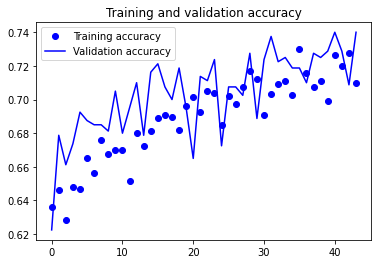

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

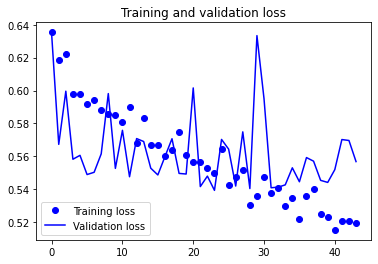

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

NameError: ignored

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

NameError: ignored

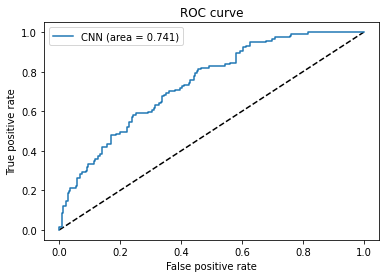

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

NameError: ignored

In [ ]:
#free RAM 
del model
del conv_base

## 3.5.0 All-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 8s 77ms/step - loss: 0.9897 - acc: 0.5733 - val_loss: 0.6008 - val_acc: 0.6662
Epoch 2/30
93/93 [==============================] - 7s 75ms/step - loss: 0.6198 - acc: 0.6246 - val_l

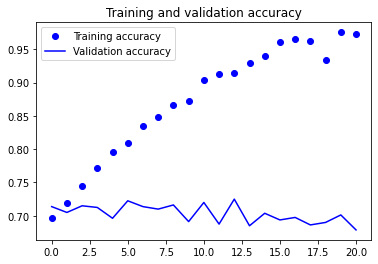

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

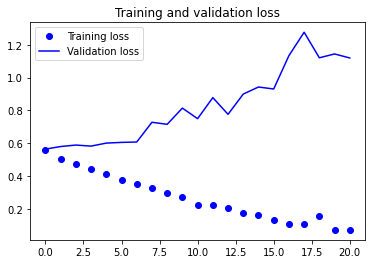

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 56ms/step - loss: 0.6274 - acc: 0.6313

---------------------------------
Accuracy: 63.13 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69       219
         1.0       0.47      0.62      0.54       117

    accuracy                           0.62       336
   macro avg       0.61      0.62      0.61       336
weighted avg       0.66      0.62      0.63       336



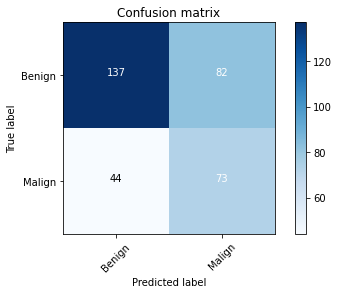

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

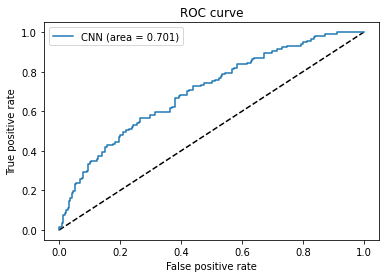

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  73
FP:  82
TN:  137
FN:  44

TPR(Recall): 		 0.6239
FPR: 			 0.3744

Precision: 		 0.471
TNR(Specificity): 	 0.6256


In [ ]:
#free RAM 
del model
del conv_base

## 3.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 13s 134ms/step - loss: 0.7980 - acc: 0.5811 - val_loss: 0.6042 - val_acc: 0.6687
Epoch 2/30
93/93 [==============================] - 12s 133ms/step - loss: 0.6563 - acc: 0.6100 - v

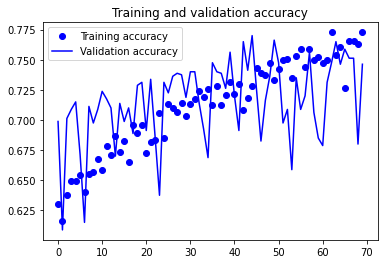

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

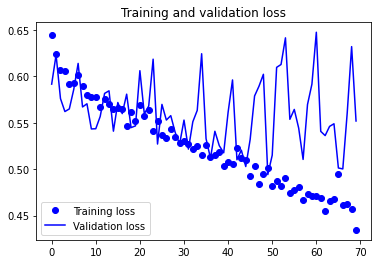

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 56ms/step - loss: 0.5493 - acc: 0.7250

---------------------------------
Accuracy: 72.50 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       219
         1.0       0.58      0.71      0.64       117

    accuracy                           0.72       336
   macro avg       0.70      0.72      0.71       336
weighted avg       0.74      0.72      0.73       336



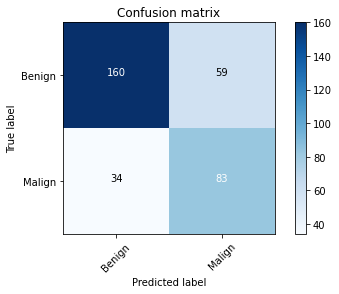

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

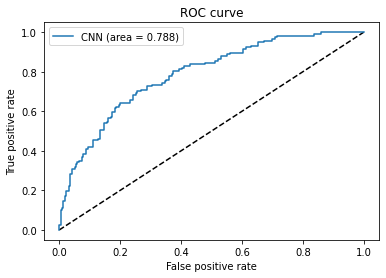

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  83
FP:  59
TN:  160
FN:  34

TPR(Recall): 		 0.7094
FPR: 			 0.2694

Precision: 		 0.5845
TNR(Specificity): 	 0.7306


In [ ]:
#free RAM 
del model
del conv_base

## 3.5.2 All-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_DA_GCN')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 21s 140ms/step - loss: 0.9429 - acc: 0.5562 - val_loss: 0.6507 - val_acc: 0.6012
Epoch 2/100
93/93 [==============================] - 12s 132ms/step - loss: 0.6196 - acc: 0.6343 - v

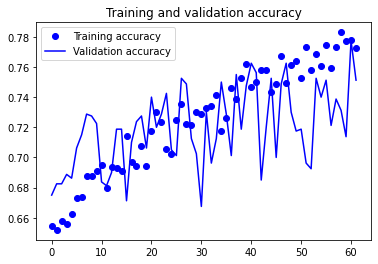

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

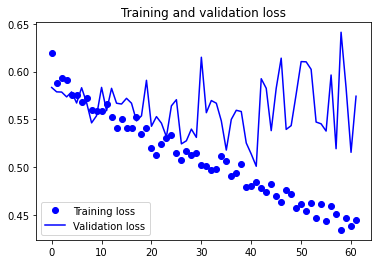

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 57ms/step - loss: 0.5467 - acc: 0.7156

---------------------------------
Accuracy: 71.56 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81       219
         1.0       0.71      0.29      0.41       117

    accuracy                           0.71       336
   macro avg       0.71      0.61      0.61       336
weighted avg       0.71      0.71      0.67       336



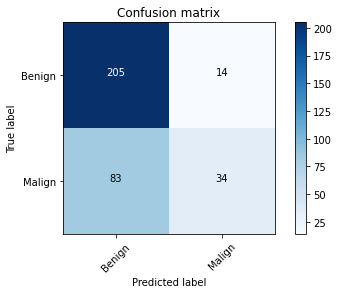

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

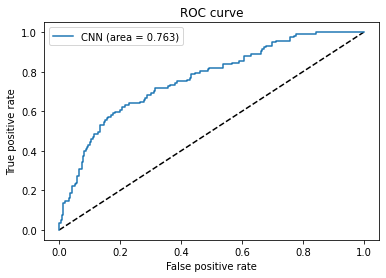

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  34
FP:  14
TN:  205
FN:  83

TPR(Recall): 		 0.2906
FPR: 			 0.0639

Precision: 		 0.7083
TNR(Specificity): 	 0.9361


In [ ]:
#free RAM 
del model
del conv_base

##3.6.0 All-Fine-Tuning Strategy With Minority Class Oversampling Through Data Augmentation & GCN

In [ ]:
#minority class oversampling through data augmentation
def oversample_augmentation(dataset, labels, scale_factor_m, scale_factor_b):
  unique, counts = np.unique(labels, return_counts=True)
  num_benign = counts[0]
  num_malign = counts[1]

  zipped = list(zip(dataset, labels))

  benign_images = np.zeros((num_benign,) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels = np.zeros((num_benign,))                       #(num_benign, )
  malign_images = np.zeros((num_malign,) +  dataset[0].shape)   #(num_malign, 150, 150, 1)
  malign_labels = np.zeros((num_malign,))                       #(num_malign, )

  #Benign samples:  1568
  #Malign samples:  1108

  benign_idx = 0
  malign_idx = 0
  for image, label in zipped:
    #get benign samples only
    if label == 0:
      benign_images[benign_idx] = image 
      benign_labels[benign_idx] = label 
      benign_idx += 1
    #get malign samples only
    elif label == 1:
      malign_images[malign_idx] = image 
      malign_labels[malign_idx] = label 
      malign_idx += 1

  #malign class oversampling through data augmentation
  malign_images_aug = np.zeros((int(num_benign*scale_factor_m),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  malign_labels_aug = np.zeros((int(num_benign*scale_factor_m),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(malign_images, malign_labels, batch_size=BATCH_size):
    malign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    malign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_m):
      break
  
  #benign class oversampling through data augmentation
  benign_images_aug = np.zeros((int(num_benign*scale_factor_b),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels_aug = np.zeros((int(num_benign*scale_factor_b),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(benign_images, benign_labels, batch_size=BATCH_size):
    benign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    benign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_b):
      break
  
  #merge classes back
  train = np.concatenate((malign_images_aug, benign_images_aug), axis=0)
  labels = np.concatenate((malign_labels_aug, benign_labels_aug), axis=0)
  
  #print(malign_images_aug.shape)
  #print(malign_labels_aug.shape)
  #print(benign_images.shape)
  #print(benign_labels.shape)

  #shuffle data
  train, labels = shuffle_dataset(train, labels)

  return train, labels

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
scale_factor_m = 1.2       # malign_samples/benign_samples ratio
scale_factor_b = 1.1
os_train_images, os_train_labels = oversample_augmentation(train_images_split, train_labels_split, scale_factor_m, scale_factor_b)

print(os_train_images.shape)
print(os_train_labels.shape)

(2570, 150, 150, 3)
(2570,)


In [ ]:
unique, counts = np.unique(os_train_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1207 1317]


In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_MCO_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(os_train_images) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(os_train_images) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
126/126 [==============================] - 25s 132ms/step - loss: 0.8905 - acc: 0.5211 - val_loss: 0.7001 - val_acc: 0.4125
Epoch 2/100
126/126 [==============================] - 16s 128ms/step - loss: 0.6929 - acc: 0.5217

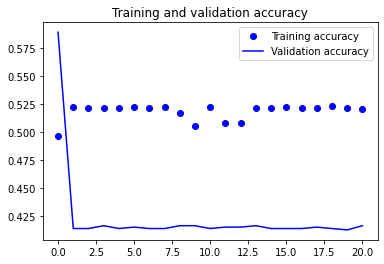

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

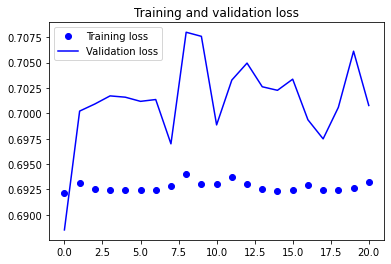

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savef

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 59ms/step - loss: 0.6837 - acc: 0.6500

---------------------------------
Accuracy: 65.00 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       219
         1.0       0.00      0.00      0.00       117

    accuracy                           0.65       336
   macro avg       0.33      0.50      0.39       336
weighted avg       0.42      0.65      0.51       336



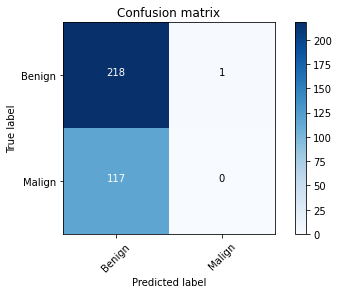

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

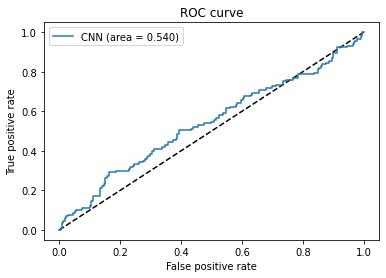

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  0
FP:  1
TN:  218
FN:  117

TPR(Recall): 		 0.0
FPR: 			 0.0046

Precision: 		 0.0
TNR(Specificity): 	 0.9954


In [ ]:
#free RAM 
del model
del conv_base

##3.6.1 All-Fine-Tuning Strategy With Minority Class Oversampling Through Data Augmentation 

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
scale_factor_m = 1.58       # malign_samples/benign_samples ratio
scale_factor_b = 1.25
os_train_images, os_train_labels = oversample_augmentation(train_images_split, train_labels_split, scale_factor_m, scale_factor_b)

print(os_train_images.shape)
print(os_train_labels.shape)

(3064, 150, 150, 3)
(3064,)


In [ ]:
unique, counts = np.unique(os_train_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1353 1711]


In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_O_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(os_train_images) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(os_train_images) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
153/153 [==============================] - 28s 129ms/step - loss: 0.8910 - acc: 0.4972 - val_loss: 0.8244 - val_acc: 0.3950
Epoch 2/100
153/153 [==============================] - 19s 123ms/step - loss: 0.7036 - acc: 0.5202

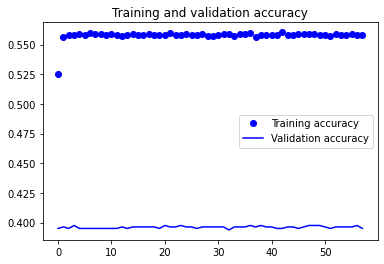

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

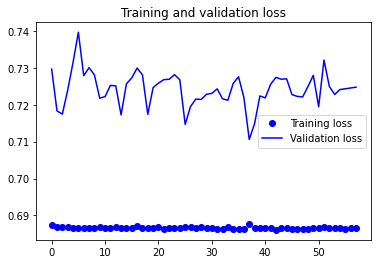

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 57ms/step - loss: 0.7008 - acc: 0.3750

---------------------------------
Accuracy: 37.50 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.86      0.05      0.10       219
         1.0       0.36      0.98      0.52       117

    accuracy                           0.38       336
   macro avg       0.61      0.52      0.31       336
weighted avg       0.68      0.38      0.25       336



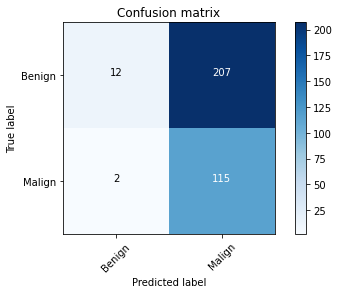

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

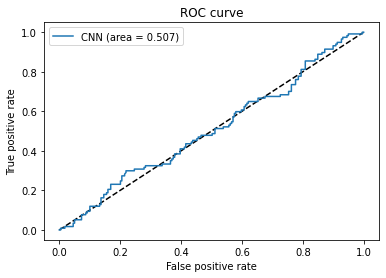

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  115
FP:  207
TN:  12
FN:  2

TPR(Recall): 		 0.9829
FPR: 			 0.9452

Precision: 		 0.3571
TNR(Specificity): 	 0.0548


In [ ]:
#free RAM 
del model
del conv_base
del os_train_images
del os_train_labels
del train_images_split
del train_labels_split
del valid_images_split
del valid_labels_split

# 4.ResNet50

##4.1.0 0-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50_0FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

KeyboardInterrupt: ignored

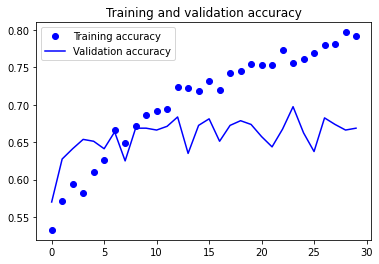

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

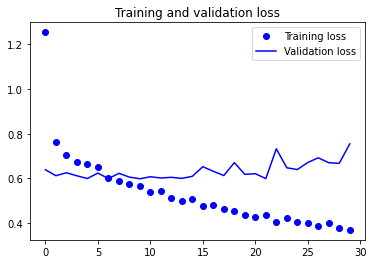

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 37ms/step - loss: 0.5929 - acc: 0.6906

---------------------------------
Accuracy: 69.06 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       219
         1.0       0.56      0.46      0.51       117

    accuracy                           0.69       336
   macro avg       0.65      0.63      0.64       336
weighted avg       0.68      0.69      0.68       336



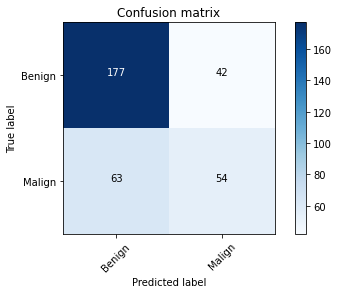

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

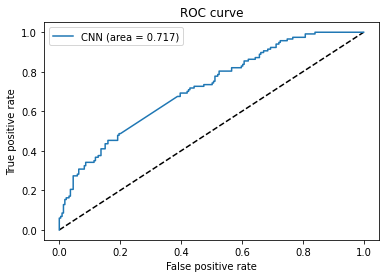

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  54
FP:  42
TN:  177
FN:  63

TPR(Recall): 		 0.4615
FPR: 			 0.1918

Precision: 		 0.5625
TNR(Specificity): 	 0.8082


In [ ]:
#free RAM 
del model
del conv_base

##4.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50_0FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

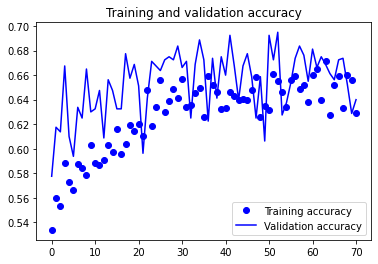

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

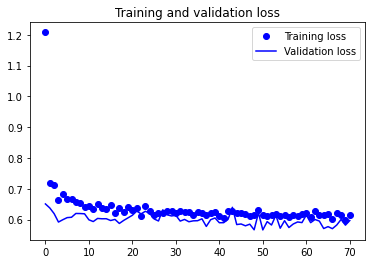

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 39ms/step - loss: 0.6117 - acc: 0.7000

---------------------------------
Accuracy: 70.00 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       219
         1.0       0.56      0.56      0.56       117

    accuracy                           0.69       336
   macro avg       0.66      0.66      0.66       336
weighted avg       0.69      0.69      0.69       336



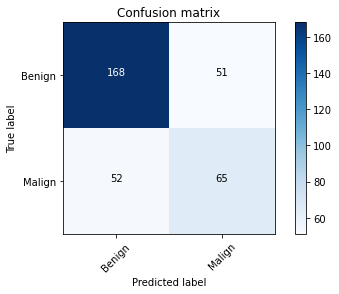

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

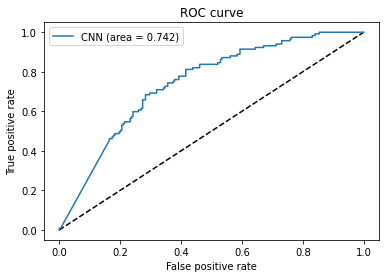

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  65
FP:  51
TN:  168
FN:  52

TPR(Recall): 		 0.5556
FPR: 			 0.2329

Precision: 		 0.5603
TNR(Specificity): 	 0.7671


In [ ]:
#free RAM 
del model
del conv_base

##4.2.0 1-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_1FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last ResNet module
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block3_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)              

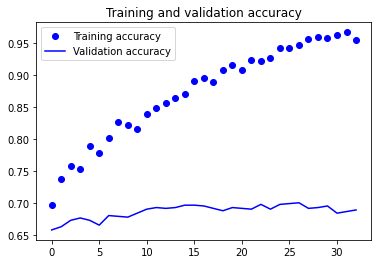

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

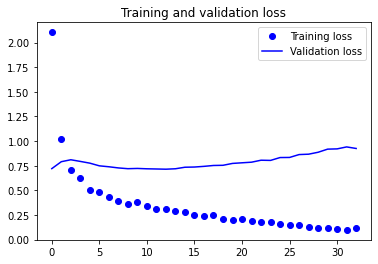

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 34ms/step - loss: 0.5998 - acc: 0.6562

---------------------------------
Accuracy: 65.62 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73       219
         1.0       0.50      0.56      0.53       117

    accuracy                           0.65       336
   macro avg       0.63      0.63      0.63       336
weighted avg       0.66      0.65      0.66       336



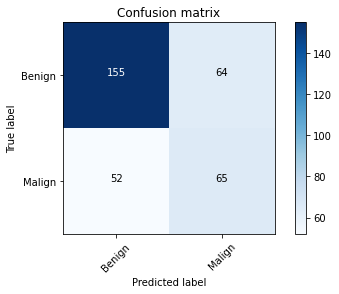

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

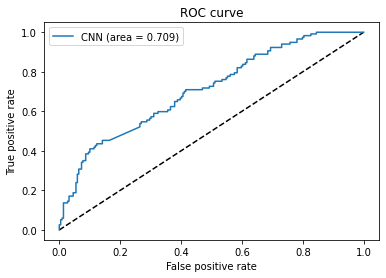

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  65
FP:  64
TN:  155
FN:  52

TPR(Recall): 		 0.5556
FPR: 			 0.2922

Precision: 		 0.5039
TNR(Specificity): 	 0.7078


In [ ]:
#free RAM 
del model
del conv_base

##4.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load ResNet50 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_1FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last ResNet module
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block3_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

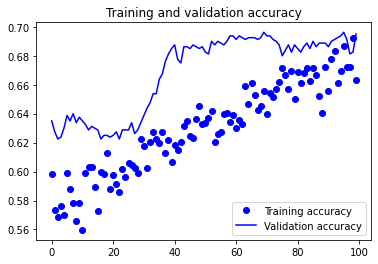

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

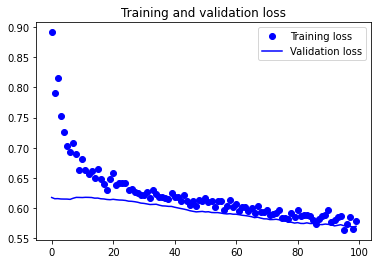

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 39ms/step - loss: 0.5833 - acc: 0.6562

---------------------------------
Accuracy: 65.62 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73       219
         1.0       0.50      0.49      0.49       117

    accuracy                           0.65       336
   macro avg       0.61      0.61      0.61       336
weighted avg       0.65      0.65      0.65       336



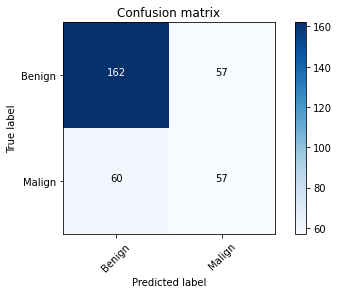

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

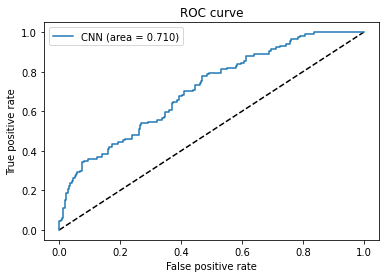

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  57
FP:  57
TN:  162
FN:  60

TPR(Recall): 		 0.4872
FPR: 			 0.2603

Precision: 		 0.5
TNR(Specificity): 	 0.7397


In [ ]:
#free RAM 
del model
del conv_base

##4.3.0 2-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_2FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 ResNet modules
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block2_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

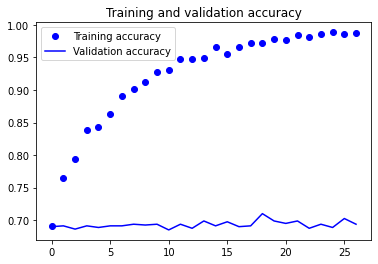

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

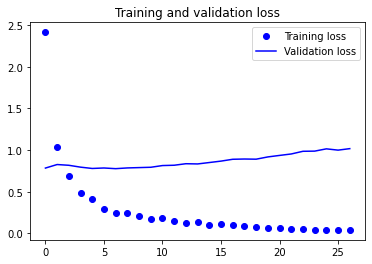

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 82ms/step - loss: 0.9253 - acc: 0.6750

---------------------------------
Accuracy: 67.50 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       219
         1.0       0.52      0.56      0.54       117

    accuracy                           0.67       336
   macro avg       0.64      0.64      0.64       336
weighted avg       0.67      0.67      0.67       336



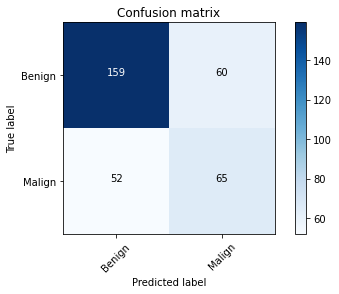

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

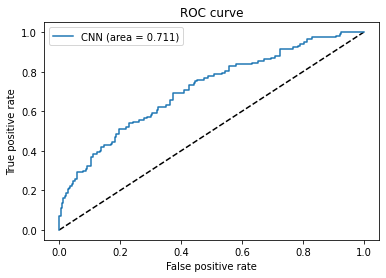

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  65
FP:  60
TN:  159
FN:  52

TPR(Recall): 		 0.5556
FPR: 			 0.274

Precision: 		 0.52
TNR(Specificity): 	 0.726


In [ ]:
#free RAM 
del model
del conv_base

##4.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_2FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 ResNet modules
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block2_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

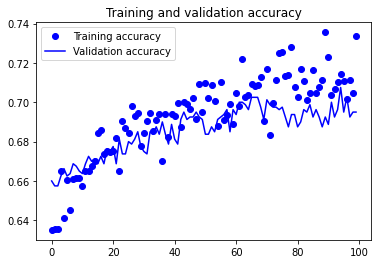

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

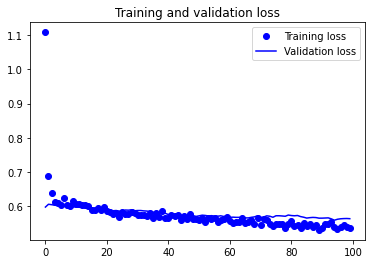

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 2s 90ms/step - loss: 0.5589 - acc: 0.6906

---------------------------------
Accuracy: 69.06 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       219
         1.0       0.55      0.53      0.54       117

    accuracy                           0.68       336
   macro avg       0.65      0.65      0.65       336
weighted avg       0.68      0.68      0.68       336



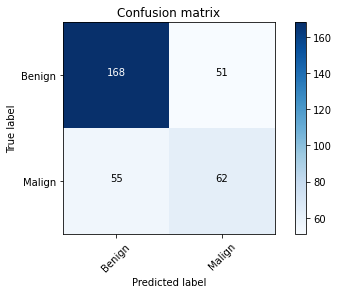

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

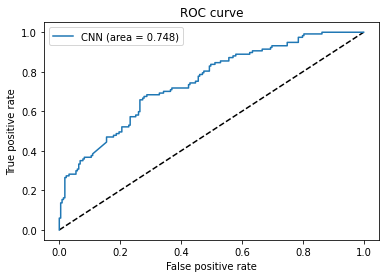

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  62
FP:  51
TN:  168
FN:  55

TPR(Recall): 		 0.5299
FPR: 			 0.2329

Precision: 		 0.5487
TNR(Specificity): 	 0.7671


In [ ]:
#free RAM 
del model
del conv_base

##4.4.0 3-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_3FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 ResNet modules
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block1_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)              

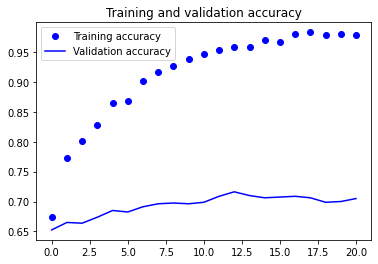

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

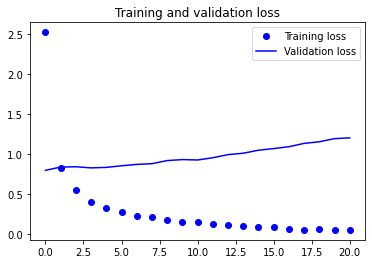

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 82ms/step - loss: 0.8775 - acc: 0.7156

---------------------------------
Accuracy: 71.56 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       219
         1.0       0.59      0.56      0.57       117

    accuracy                           0.71       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.71      0.71       336



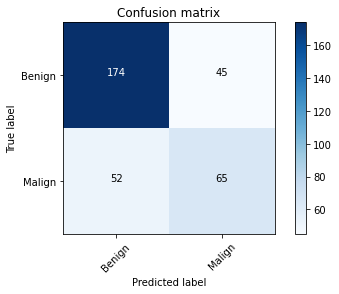

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

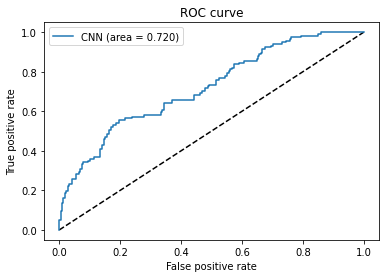

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  65
FP:  45
TN:  174
FN:  52

TPR(Recall): 		 0.5556
FPR: 			 0.2055

Precision: 		 0.5909
TNR(Specificity): 	 0.7945


In [ ]:
#free RAM 
del model
del conv_base

##4.4.1 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 ResNet modules
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block1_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_12 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)             

KeyboardInterrupt: ignored

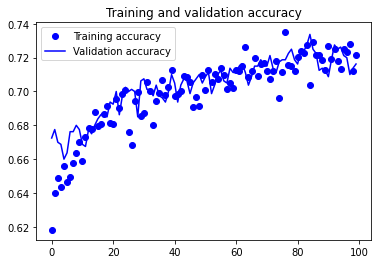

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

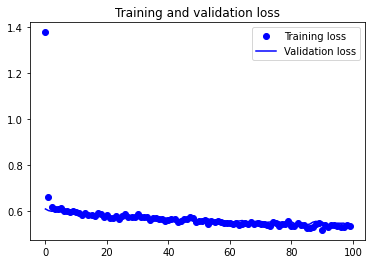

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 2s 91ms/step - loss: 0.5761 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       219
         1.0       0.57      0.60      0.59       117

    accuracy                           0.71       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.71      0.71       336



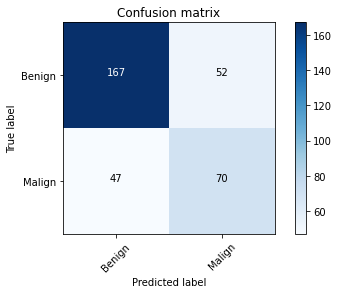

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

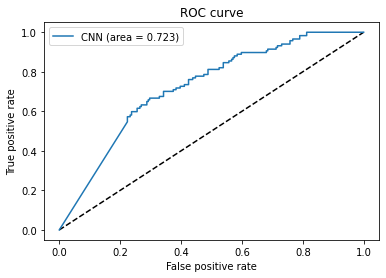

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

In [ ]:
#free RAM 
del model
del conv_base

##4.4.2 3-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 ResNet modules
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "conv5_block1_preact_bn":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)              

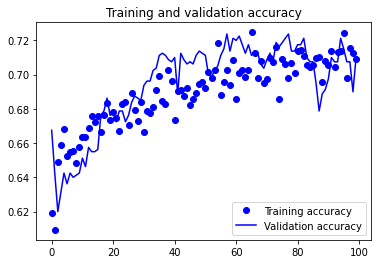

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

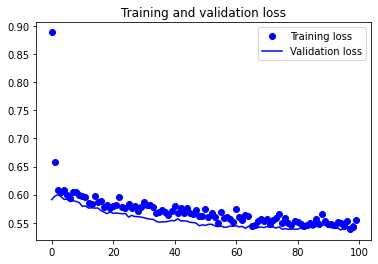

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 37ms/step - loss: 0.5620 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80       219
         1.0       0.64      0.31      0.42       117

    accuracy                           0.70       336
   macro avg       0.68      0.61      0.61       336
weighted avg       0.69      0.70      0.66       336



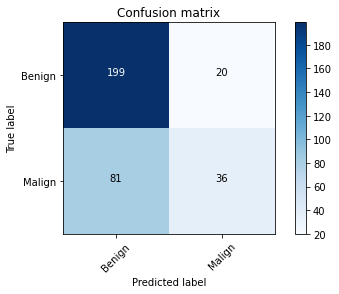

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

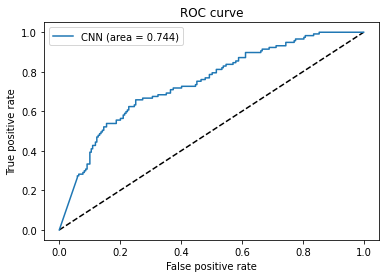

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  36
FP:  20
TN:  199
FN:  81

TPR(Recall): 		 0.3077
FPR: 			 0.0913

Precision: 		 0.6429
TNR(Specificity): 	 0.9087


In [ ]:
#free RAM 
del model
del conv_base

##4.5.0 All-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_ALLFT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last all ResNet modules
for layer in model.layers:
  layer.trainable = True 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

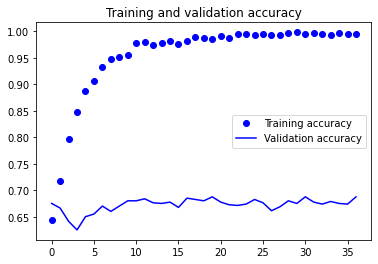

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

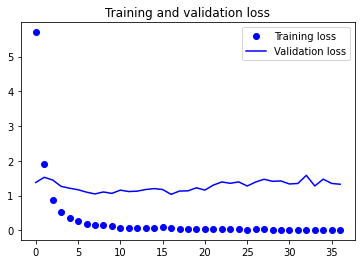

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 38ms/step - loss: 0.5612 - acc: 0.7063

---------------------------------
Accuracy: 70.63 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       219
         1.0       0.58      0.56      0.57       117

    accuracy                           0.71       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.71      0.70       336



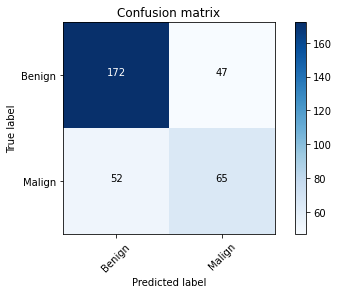

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

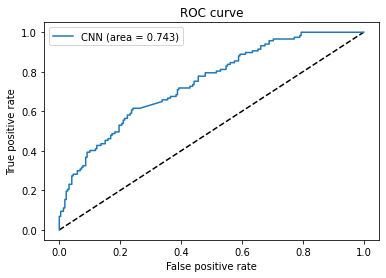

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  65
FP:  47
TN:  172
FN:  52

TPR(Recall): 		 0.5556
FPR: 			 0.2146

Precision: 		 0.5804
TNR(Specificity): 	 0.7854


In [ ]:
#free RAM 
del model
del conv_base

##4.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_ALLFT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last all ResNet modules
for layer in model.layers:
  layer.trainable = True 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

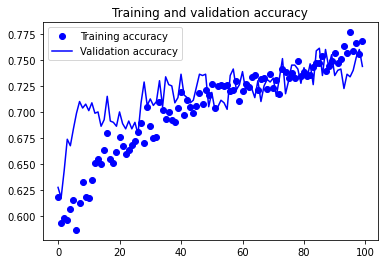

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

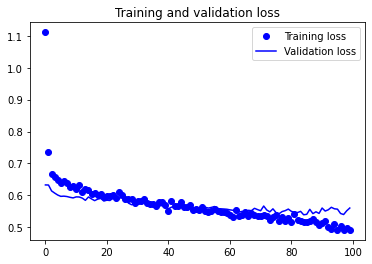

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 33ms/step - loss: 0.5953 - acc: 0.7344

---------------------------------
Accuracy: 73.44 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.68      0.74       219
         1.0       0.55      0.71      0.62       117

    accuracy                           0.69       336
   macro avg       0.68      0.70      0.68       336
weighted avg       0.72      0.69      0.70       336



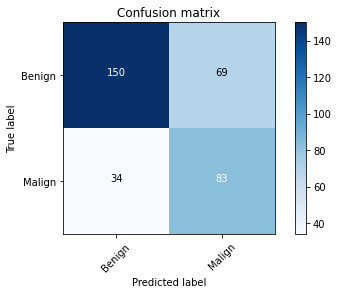

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

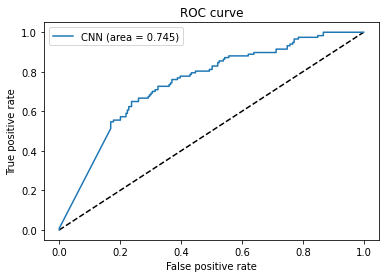

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  83
FP:  69
TN:  150
FN:  34

TPR(Recall): 		 0.7094
FPR: 			 0.3151

Precision: 		 0.5461
TNR(Specificity): 	 0.6849


In [ ]:
#free RAM 
del model
del conv_base

##4.5.2 All-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications import ResNet50V2
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = ResNet50V2(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3))

conv_base.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="ResNet50", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_ResNet50V2_ALLFT_DA_GCN')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last all ResNet modules
for layer in model.layers:
  layer.trainable = True 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

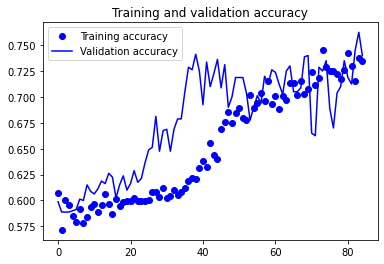

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

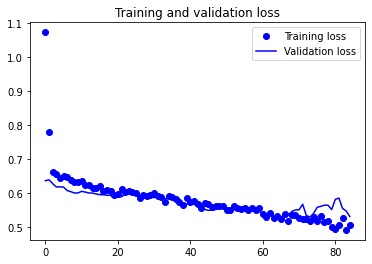

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 36ms/step - loss: 0.5953 - acc: 0.7344

---------------------------------
Accuracy: 73.44 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       219
         1.0       0.64      0.46      0.54       117

    accuracy                           0.72       336
   macro avg       0.70      0.66      0.67       336
weighted avg       0.71      0.72      0.71       336



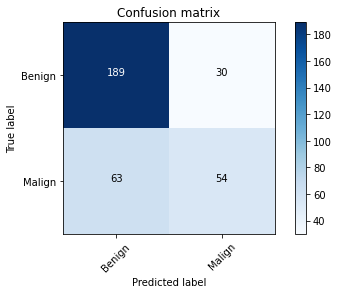

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

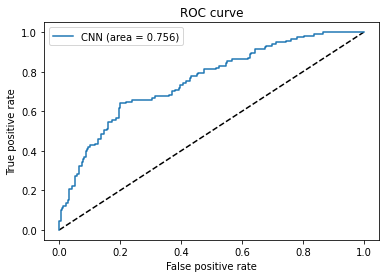

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  54
FP:  30
TN:  189
FN:  63

TPR(Recall): 		 0.4615
FPR: 			 0.137

Precision: 		 0.6429
TNR(Specificity): 	 0.863


In [ ]:
#free RAM 
del model
del conv_base

# 5.Inception V3

##5.1.0 0-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_0FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

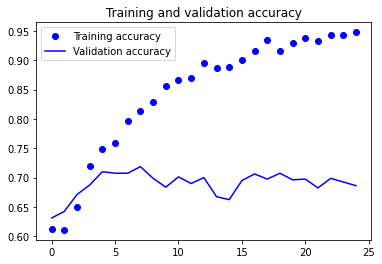

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

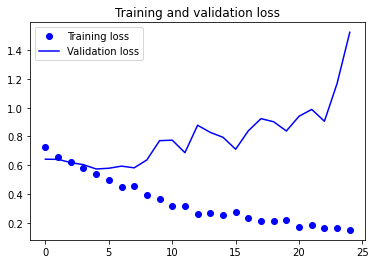

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 32ms/step - loss: 0.5707 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       219
         1.0       0.55      0.68      0.61       117

    accuracy                           0.70       336
   macro avg       0.68      0.69      0.68       336
weighted avg       0.72      0.70      0.70       336



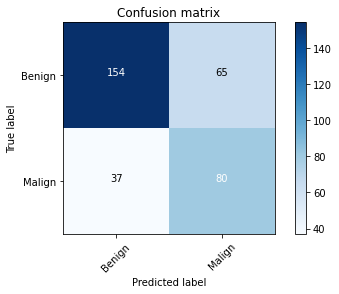

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

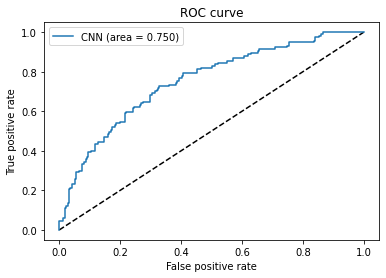

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  65
TN:  154
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.2968

Precision: 		 0.5517
TNR(Specificity): 	 0.7032


In [ ]:
#free RAM 
del model
del conv_base

##5.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 74, 74, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 74, 74, 32)   96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 74, 74, 32)   0           batch_normalization_564[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_0FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

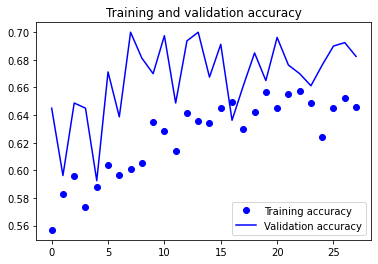

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

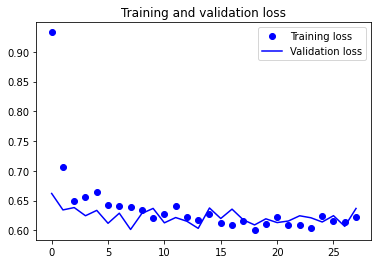

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 30ms/step - loss: 0.5917 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       219
         1.0       0.56      0.50      0.53       117

    accuracy                           0.69       336
   macro avg       0.66      0.65      0.65       336
weighted avg       0.68      0.69      0.69       336



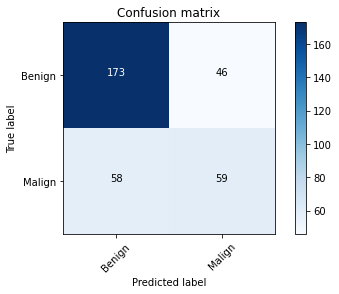

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

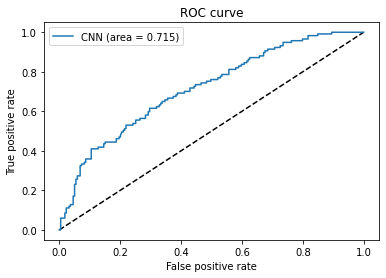

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  59
FP:  46
TN:  173
FN:  58

TPR(Recall): 		 0.5043
FPR: 			 0.21

Precision: 		 0.5619
TNR(Specificity): 	 0.79


In [ ]:
#free RAM 
del model
del conv_base

##5.2.0 1-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 74, 74, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 74, 74, 32)   96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 74, 74, 32)   0           batch_normalization_752[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_1FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last Inception module
for layer in model.layers[:280]:
   layer.trainable = False
for layer in model.layers[280:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)              

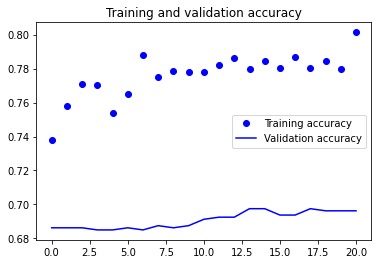

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

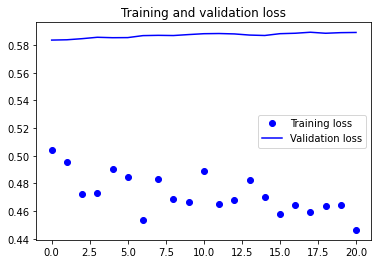

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 33ms/step - loss: 0.5676 - acc: 0.7094

---------------------------------
Accuracy: 70.94 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.77       219
         1.0       0.56      0.60      0.58       117

    accuracy                           0.70       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.70      0.70      0.70       336



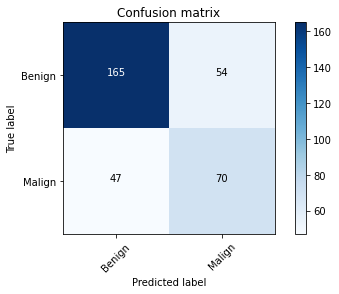

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

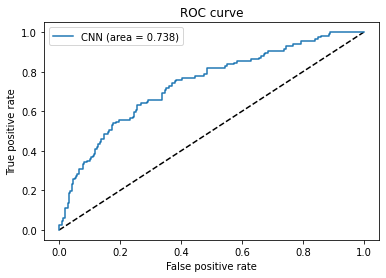

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  70
FP:  54
TN:  165
FN:  47

TPR(Recall): 		 0.5983
FPR: 			 0.2466

Precision: 		 0.5645
TNR(Specificity): 	 0.7534


In [ ]:
#free RAM 
del model
del conv_base

##5.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 74, 74, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 74, 74, 32)   96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 74, 74, 32)   0           batch_normalization_752[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_1FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last Inception module
for layer in model.layers[:280]:
   layer.trainable = False
for layer in model.layers[280:]:
   layer.trainable = True


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)              

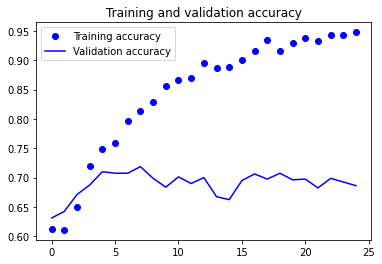

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

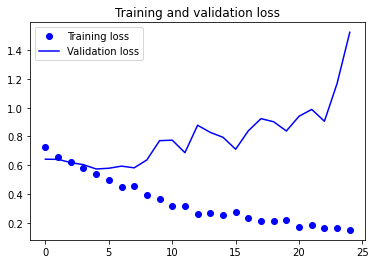

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 32ms/step - loss: 0.5707 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       219
         1.0       0.55      0.68      0.61       117

    accuracy                           0.70       336
   macro avg       0.68      0.69      0.68       336
weighted avg       0.72      0.70      0.70       336



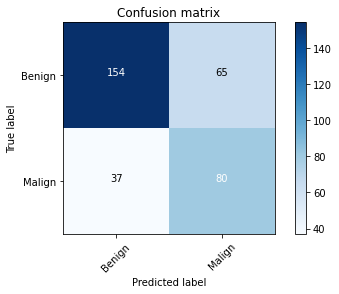

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

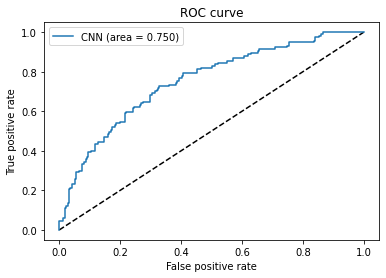

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  65
TN:  154
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.2968

Precision: 		 0.5517
TNR(Specificity): 	 0.7032


In [ ]:
#free RAM 
del model
del conv_base

##5.2.3 1-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_1FT_DA_GCN')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last Inception module
for layer in model.layers[:280]:
   layer.trainable = False
for layer in model.layers[280:]:
   layer.trainable = True


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

KeyboardInterrupt: ignored

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

NameError: ignored

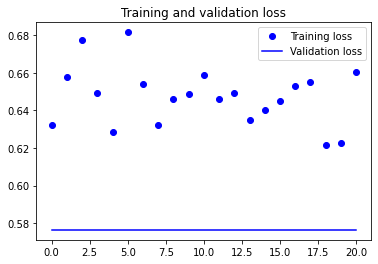

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 62ms/step - loss: 0.5784 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80       219
         1.0       0.65      0.26      0.38       117

    accuracy                           0.69       336
   macro avg       0.67      0.59      0.59       336
weighted avg       0.68      0.69      0.65       336



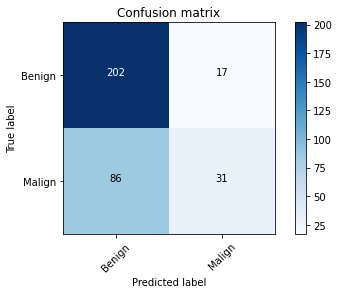

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

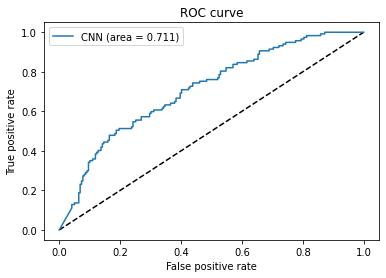

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  31
FP:  17
TN:  202
FN:  86

TPR(Recall): 		 0.265
FPR: 			 0.0776

Precision: 		 0.6458
TNR(Specificity): 	 0.9224


In [ ]:
#free RAM 
del model
del conv_base

##5.3.0 2-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_2FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 Inception modules
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

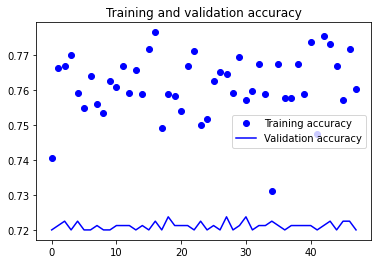

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

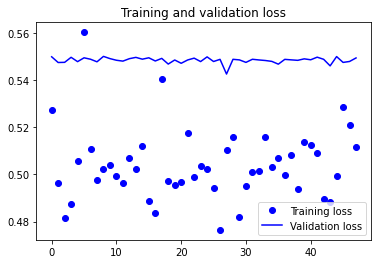

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 68ms/step - loss: 0.5559 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       219
         1.0       0.58      0.54      0.56       117

    accuracy                           0.71       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.71      0.70       336



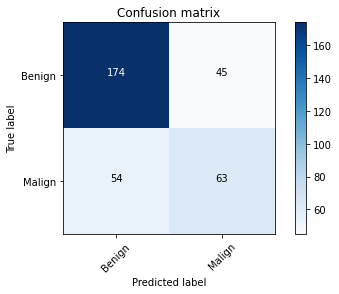

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

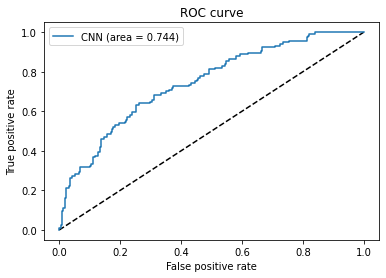

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  63
FP:  45
TN:  174
FN:  54

TPR(Recall): 		 0.5385
FPR: 			 0.2055

Precision: 		 0.5833
TNR(Specificity): 	 0.7945


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_2FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 Inception modules
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.4.0 3-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_3FT')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 Inception modules
for layer in model.layers[:218]:
   layer.trainable = False
for layer in model.layers[218:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

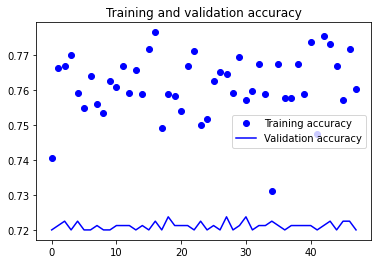

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

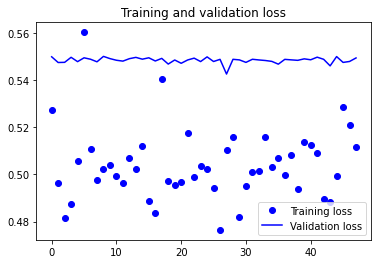

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 68ms/step - loss: 0.5559 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       219
         1.0       0.58      0.54      0.56       117

    accuracy                           0.71       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.71      0.70       336



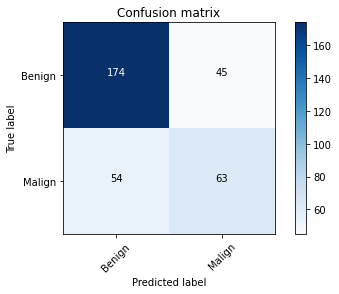

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

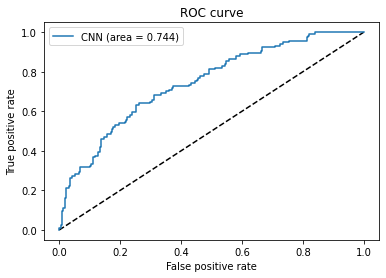

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  63
FP:  45
TN:  174
FN:  54

TPR(Recall): 		 0.5385
FPR: 			 0.2055

Precision: 		 0.5833
TNR(Specificity): 	 0.7945


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.4.1 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 Inception modules
for layer in model.layers[:218]:
   layer.trainable = False
for layer in model.layers[218:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

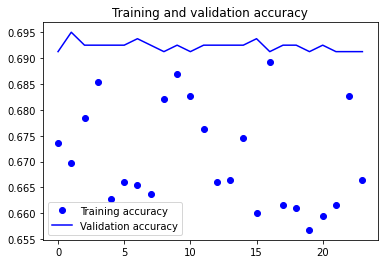

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

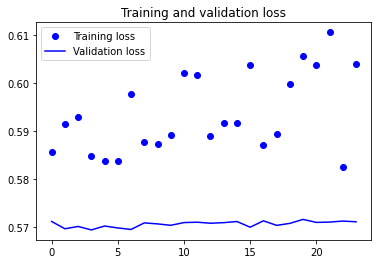

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 61ms/step - loss: 0.5726 - acc: 0.6969

---------------------------------
Accuracy: 69.69 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       219
         1.0       0.55      0.57      0.56       117

    accuracy                           0.69       336
   macro avg       0.66      0.66      0.66       336
weighted avg       0.69      0.69      0.69       336



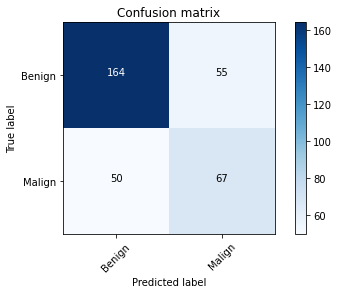

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

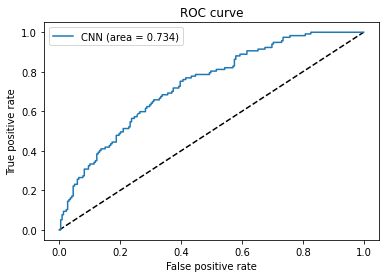

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  67
FP:  55
TN:  164
FN:  50

TPR(Recall): 		 0.5726
FPR: 			 0.2511

Precision: 		 0.5492
TNR(Specificity): 	 0.7489


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.4.2 3-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 74, 74, 32)   96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 74, 74, 32)   0           batch_normalization_564[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 Inception modules
for layer in model.layers[:218]:
   layer.trainable = False
for layer in model.layers[218:]:
   layer.trainable = True

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

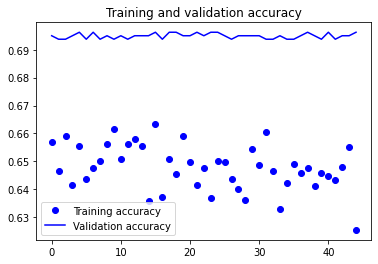

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

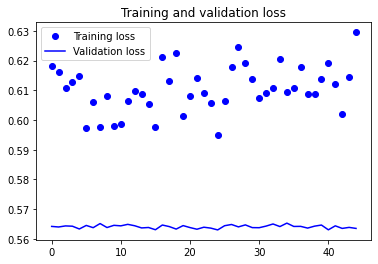

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 69ms/step - loss: 0.5774 - acc: 0.6875

---------------------------------
Accuracy: 68.75 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       219
         1.0       0.58      0.32      0.42       117

    accuracy                           0.68       336
   macro avg       0.64      0.60      0.60       336
weighted avg       0.66      0.68      0.65       336



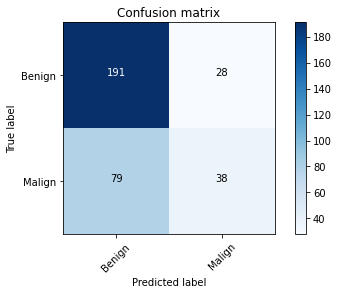

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

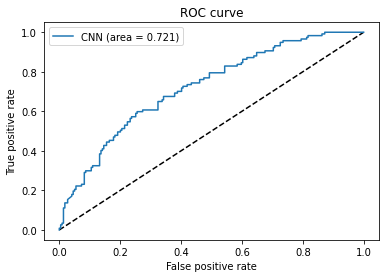

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  38
FP:  28
TN:  191
FN:  79

TPR(Recall): 		 0.3248
FPR: 			 0.1279

Precision: 		 0.5758
TNR(Specificity): 	 0.8721


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.5.0 All-Fine-Tuning Strategy Without Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=False)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_ALLFT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all Inception modules
for layer in model.layers:
   layer.trainable = True


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

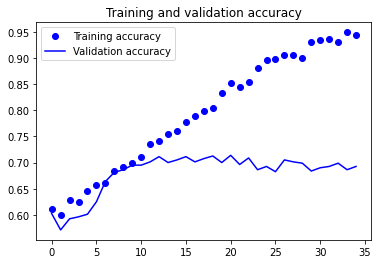

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

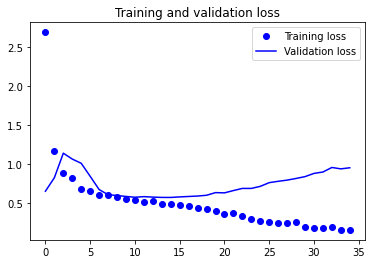

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76       219
         1.0       0.56      0.68      0.61       117

    accuracy                           0.70       336
   macro avg       0.68      0.70      0.69       336
weighted avg       0.72      0.70      0.71       336



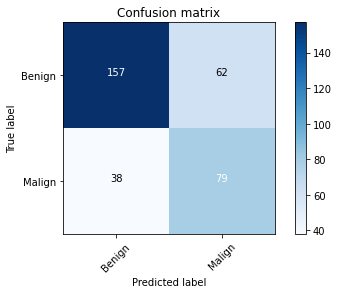

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

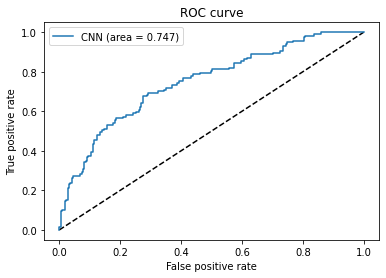

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  79
FP:  62
TN:  157
FN:  38

TPR(Recall): 		 0.6752
FPR: 			 0.2831

Precision: 		 0.5603
TNR(Specificity): 	 0.7169


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_ALLFT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all Inception modules
for layer in model.layers:
   layer.trainable = True


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-4), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

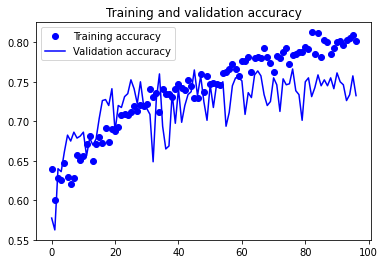

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

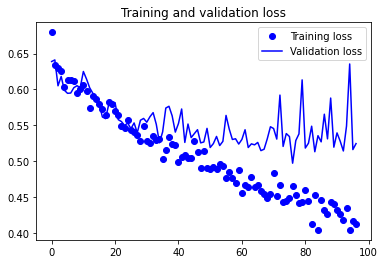

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 0s 29ms/step - loss: 0.5457 - acc: 0.6969

---------------------------------
Accuracy: 69.69 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.74       219
         1.0       0.53      0.68      0.60       117

    accuracy                           0.68       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.71      0.68      0.69       336



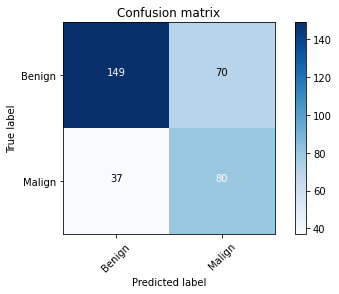

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

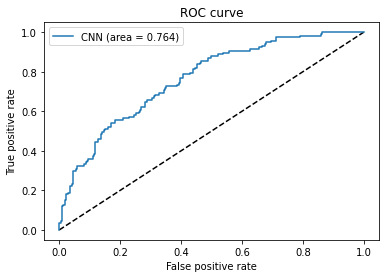

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  70
TN:  149
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.3196

Precision: 		 0.5333
TNR(Specificity): 	 0.6804


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

##5.5.2 All-Fine-Tuning Strategy With Data Augmentation & GCN

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="InceptionV3", GCN=True, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_ALLFT_DA_GCN')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all Inception modules
for layer in model.layers:
   layer.trainable = True


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-4), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)              

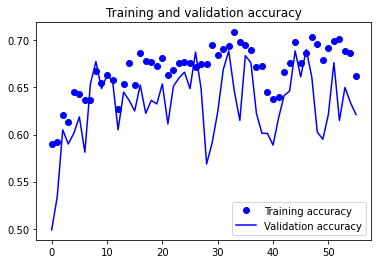

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

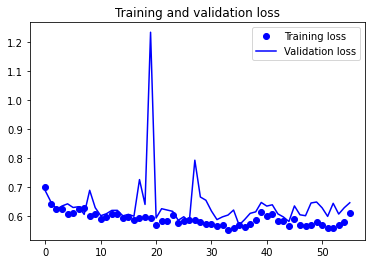

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 29ms/step - loss: 0.5968 - acc: 0.6719

---------------------------------
Accuracy: 67.19 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79       219
         1.0       0.61      0.17      0.27       117

    accuracy                           0.67       336
   macro avg       0.64      0.56      0.53       336
weighted avg       0.65      0.67      0.61       336



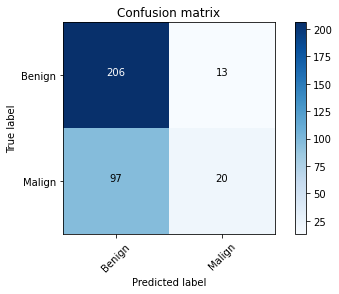

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
#plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

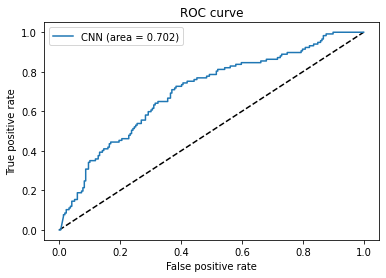

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  20
FP:  13
TN:  206
FN:  97

TPR(Recall): 		 0.1709
FPR: 			 0.0594

Precision: 		 0.6061
TNR(Specificity): 	 0.9406


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split
del valid_images_split 
del train_labels_split 
del valid_labels_split

# Model Results Report

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
zero_ft = [20, 34, 30, 35, 27, 11]
one_ft = [20, 34, 30, 35, 27, 10]
two_ft = [25, 32, 34, 20, 25, 10]
three_ft = [25, 32, 34, 20, 25, 31]
all_ft = [25, 32, 34, 20, 25, 7]

x = 3*np.arange(len(labels))  # the label locations
width = 0.42  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - 2*1.2*width, zero_ft, width, label='0FT')
rects2 = ax.bar(x - 1.2*width, one_ft, width, label='1FT')
rects3 = ax.bar(x, two_ft, width, label='2FT')
rects4 = ax.bar(x + 2*1.2*width, three_ft, width, label='3FT')
rects5 = ax.bar(x + 1.2*width, all_ft, width, label='AllFT')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()
plt.show()